In [1]:
import os
os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'  # Suppress the Intel MKL warning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from pyemd import emd
from pathlib import Path

import warnings 
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Movement Classification Class

In [7]:
class EMD_Sim_Movement:

    def __init__(self, path, normalization='median', bins= 30):

        data = pd.read_csv(path)
        data = data.set_index('Unnamed: 0')
        # rename index
        data.index.name = 'droplet_id'
        positions = list()

        for col_name, col_data in data.items():
            if col_name == '0' or col_name == '1':
                continue
                
            # Filter the columns with '_x' and '_y'
            x_columns = col_data.filter(like='_x').values 
            y_columns = col_data.filter(like='_y').values  #
            positions.append(np.vstack((x_columns, y_columns)).T)

        self.positions = positions
        self.last_frame = len(self.positions) - 1

        self.bins = bins

        assert normalization in ['median', 'mean', 'None'], "Normalization must be either 'median' or 'mean' or 'None'"
        self.norm = normalization

        # Normalization of the droplet positions
        if self.norm == 'median' or self.norm == 'mean':
            self.normalizer = 1
        else:
            self.normalizer = 1
        #  Normalize the positions by the median droplet radius
        for i in range(len(self.positions)):
            self.positions[i] /= self.normalizer
        self.emd_distances = None

    def instant_plot(self):
        # Number of scatter plots
        num_plots = len(self.positions)

        # Determine the number of rows and columns
        cols = 4
        rows = (num_plots + cols - 1) // cols  # Ceiling division to get the number of rows

        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharex=True, sharey=True)

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        for i in range(num_plots):
            max_x = np.max(self.positions[i][:, 0])
            max_y = np.max(self.positions[i][:, 1])
            axes[i].scatter(self.positions[i][:, 0], self.positions[i][:, 1], s=3)
            axes[i].set_title(f'Frame {i}')
            axes[i].set_xlim([0, max_x])
            axes[i].set_ylim([0, max_y])
            axes[i].invert_yaxis()

        # Hide any unused subplots
        for j in range(num_plots, len(axes)):
            axes[j].invert_yaxis()
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
    
    def emd_distance(self, source, target):
        # Compute the Earth Mover's Distance between two 2D point clouds

        # Get the maximum x and y coordinates
        self.x_max = max(np.max(source[:, 0]), np.max(target[:, 0]))
        self.y_max = max(np.max(source[:, 1]), np.max(target[:, 1]))

        # Convert 2D arrays to histograms (example using simple binning)
        hist1, xedges, yedges = np.histogram2d(source[:, 0], source[:, 1], bins=self.bins, range=[[0, self.x_max], [0, self.y_max]])
        hist2, _, _ = np.histogram2d(target[:, 0], target[:, 1], bins=self.bins, range=[[0, self.x_max], [0, self.y_max]])

        # Normalize histograms to create probability distributions
        self.hist1 = hist1 / np.sum(hist1)
        self.hist2 = hist2 / np.sum(hist2)

        # Flatten histograms to 1D arrays
        hist1_flat = self.hist1.flatten()
        hist2_flat = self.hist2.flatten()

        # Create a distance matrix using Euclidean distance
        bin_centers = np.array([(x, y) for x in (xedges[:-1] + xedges[1:]) / 2 for y in (yedges[:-1] + yedges[1:]) / 2])

        # Reshape bin_centers for broadcasting
        bin_centers_x = bin_centers[:, 0].reshape(-1, 1)
        bin_centers_y = bin_centers[:, 1].reshape(-1, 1)

        # Compute the squared differences in a vectorized manner
        diff_x = bin_centers_x - bin_centers_x.T
        diff_y = bin_centers_y - bin_centers_y.T

        # Compute the distance matrix
        distance_matrix = np.sqrt(diff_x ** 2 + diff_y ** 2)

        # Calculate the Earth Mover's Distance
        emd_dist = emd(hist1_flat, hist2_flat, distance_matrix)

        return emd_dist
    
    def emd_(self, first_frame=0, last_frame=None, print_=True):

        if last_frame is None:
            last_frame = self.last_frame
                
        self.emd_distances = list()
        for i in range(first_frame, last_frame):
            source = self.positions[i]
            target = self.positions[i+1]
            self.emd_distances.append(self.emd_distance(source, target))

        self.emd_distances = np.array(self.emd_distances)

        if print_:
            print(f"Earth Mover's Distance with {self.bins} bins:")
            print(f"Mean: {np.mean(self.emd_distances):.3f} (std: {np.std(self.emd_distances):.3f})")
            print(f"Median: {np.median(self.emd_distances):.3f}")
            print()

        return self.emd_distances
    
    def plot_emd(self, source_frame=0, target_frame=1):
        assert 0 <= source_frame < len(self.frames), f"source_frame must be in the range [0, {len(self.frames) - 1}]"
        assert 0 <= target_frame < len(self.frames), f"target_frame must be in the range [0, {len(self.frames) - 1}]"
        assert source_frame != target_frame, "source_frame and target_frame must be different"
        assert source_frame < target_frame, "source_frame must be less than target_frame"

        source = self.positions[source_frame]
        target = self.positions[target_frame]
    
        emd_ = self.emd_distance(source, target)

        source = source * self.normalizer
        target = target * self.normalizer

        max_x = max(np.max(source[:, 0]), np.max(target[:, 0]))
        max_y = max(np.max(source[:, 1]), np.max(target[:, 1]))
        # Plot the Droplets
        fig = plt.figure(figsize=(16, 8))
        gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

        # Plot the both frames in one scatter plot
        ax1 = fig.add_subplot(gs[0:2, 0:2])
        ax1.set_title(f'Droplets in Source and Target frames with EMD: {emd_:.4f}', fontsize=16)
        ax1.scatter(source[:, 0], source[:, 1], alpha=0.6, c='blue', label=f'Source', s=10)
        ax1.scatter(target[:, 0], target[:, 1], alpha=0.6, c='red', label=f'Target)', s=10)
        ax1.set_xlim([0, max_x])
        ax1.set_ylim([0, max_y])
        ax1.invert_yaxis()  # Invert y-axis to make (0, 0) the top-left corner
        ax1.legend(loc='upper right')

        # Plot the histogram of the source frame
        ax2 = fig.add_subplot(gs[0, 2])
        ax2.set_title(f'2D-Histogram of Source frame', fontsize=16)
        ax2.hist2d(source[:, 0], source[:, 1], bins=self.bins, cmap='Blues')
        ax2.invert_yaxis()

        # Plot the histogram of the target frame
        ax3 = fig.add_subplot(gs[1, 2])
        ax3.set_title(f'2D-Histogram of Target frame', fontsize=16)
        ax3.hist2d(target[:, 0], target[:, 1], bins=self.bins, cmap='Reds')
        ax3.invert_yaxis()

        # Plot source frame scatter plot
        ax4 = fig.add_subplot(gs[0, 3])
        ax4.set_title(f'Droplets in Source frame', fontsize=16)
        ax4.scatter(source[:, 0], source[:, 1], alpha=0.6, c='blue', s=2)
        ax4.set_xlim([0, max_x])
        ax4.set_ylim([0, max_y])
        ax4.invert_yaxis()

        # Plot target frame scatter plot
        ax5 = fig.add_subplot(gs[1, 3])
        ax5.set_title(f'Droplets in Target frame', fontsize=16)
        ax5.scatter(target[:, 0], target[:, 1], alpha=0.6, c='red', s=2)
        ax5.set_xlim([0, max_x])
        ax5.set_ylim([0, max_y])
        ax5.invert_yaxis()

        plt.tight_layout()
        plt.show()

    def plot_positions(self):
        # Number of scatter plots
        num_plots = len(self.positions)

        # Determine the number of rows and columns
        cols = 4
        rows = (num_plots + cols - 1) // cols  # Ceiling division to get the number of rows

        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharex=True, sharey=True)

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        for i in range(num_plots):
            axes[i].scatter(self.positions[i][:, 0]*self.normalizer, self.positions[i][:, 1]*self.normalizer, s=3)
            axes[i].set_title(f'Frame {i}')
            axes[i].set_xlim([0, np.max(self.positions[i][:, 0]*self.normalizer)])
            axes[i].set_ylim([0, np.max(self.positions[i][:, 1]*self.normalizer)])
            axes[i].invert_yaxis()

        # Hide any unused subplots
        for j in range(num_plots, len(axes)):
            axes[j].invert_yaxis()
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

### Get all RESULTS

In [9]:
def all_plot(MVT, clip):

    # EMD
    dist_emd = MVT.emd_()

    # Plot the EMD
    fig = plt.figure(figsize=(18, 5)) 

    # Plot the both frames in one scatter plot
    ax1 = fig.add_subplot(111)
    ax1.set_title('Earth Mover\'s Distance')
    ax1.plot(range(1, len(dist_emd)+1), dist_emd, label='Earth Mover\'s Distance', color='blue')
    ax1.set_title('Earth Mover\'s Distance')
    ax1.set_xlabel('Step')
    ax1.grid(True)

    plt.tight_layout()
    plt.show()

    return dist_emd

## Small

#### 1848

Earth Mover's Distance with 30 bins:
Mean: 1.514 (std: 0.164)
Median: 1.550



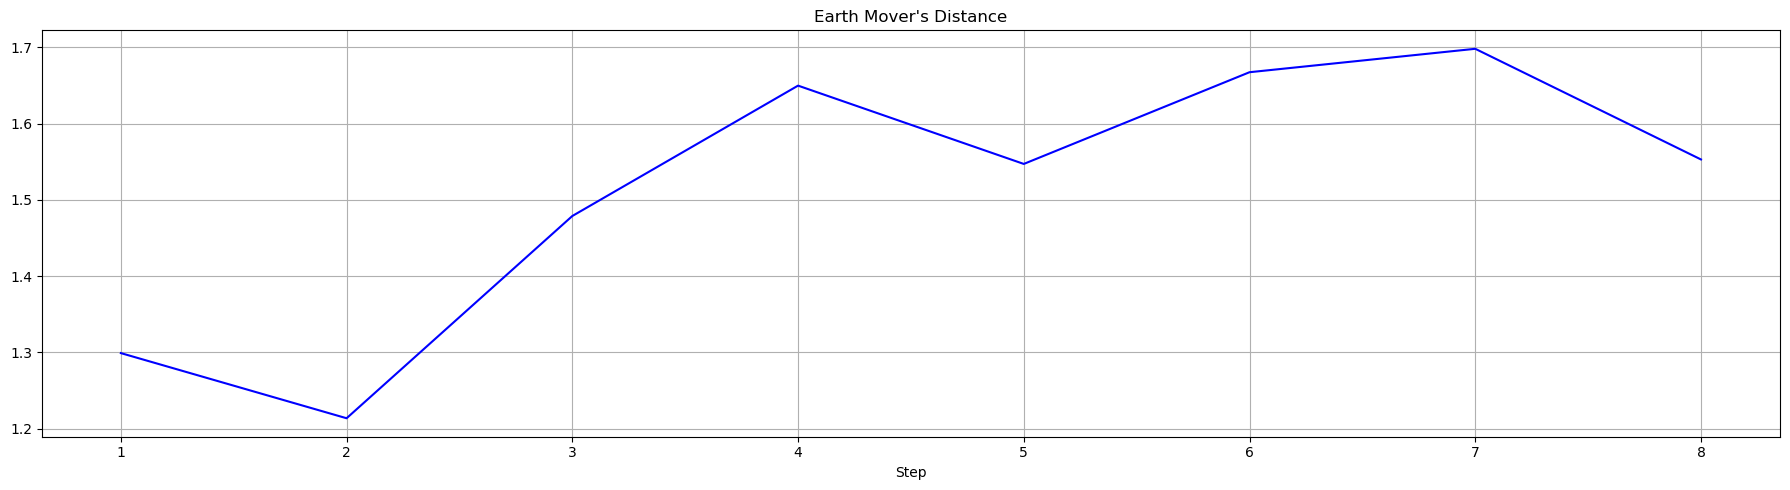

In [21]:
clip = 'small_mvt_1848'
EMD_small_mvt_1848 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

small_mvt_1848_emd = all_plot(EMD_small_mvt_1848, clip)

#### 6000

Earth Mover's Distance with 30 bins:
Mean: 0.096 (std: 0.014)
Median: 0.102



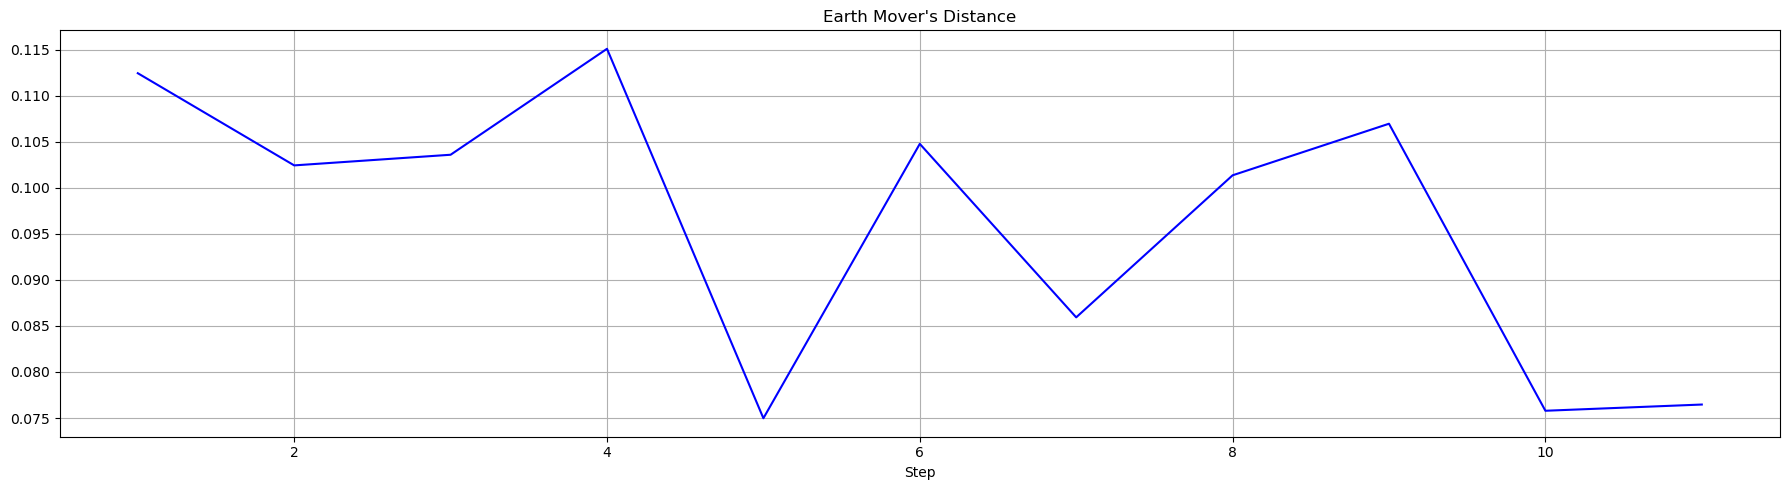

In [22]:
clip = 'small_mvt_6000'
EMD_small_mvt_6000 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

small_mvt_6000_emd = all_plot(EMD_small_mvt_6000, clip)

#### 20000

Earth Mover's Distance with 30 bins:
Mean: 0.071 (std: 0.010)
Median: 0.067



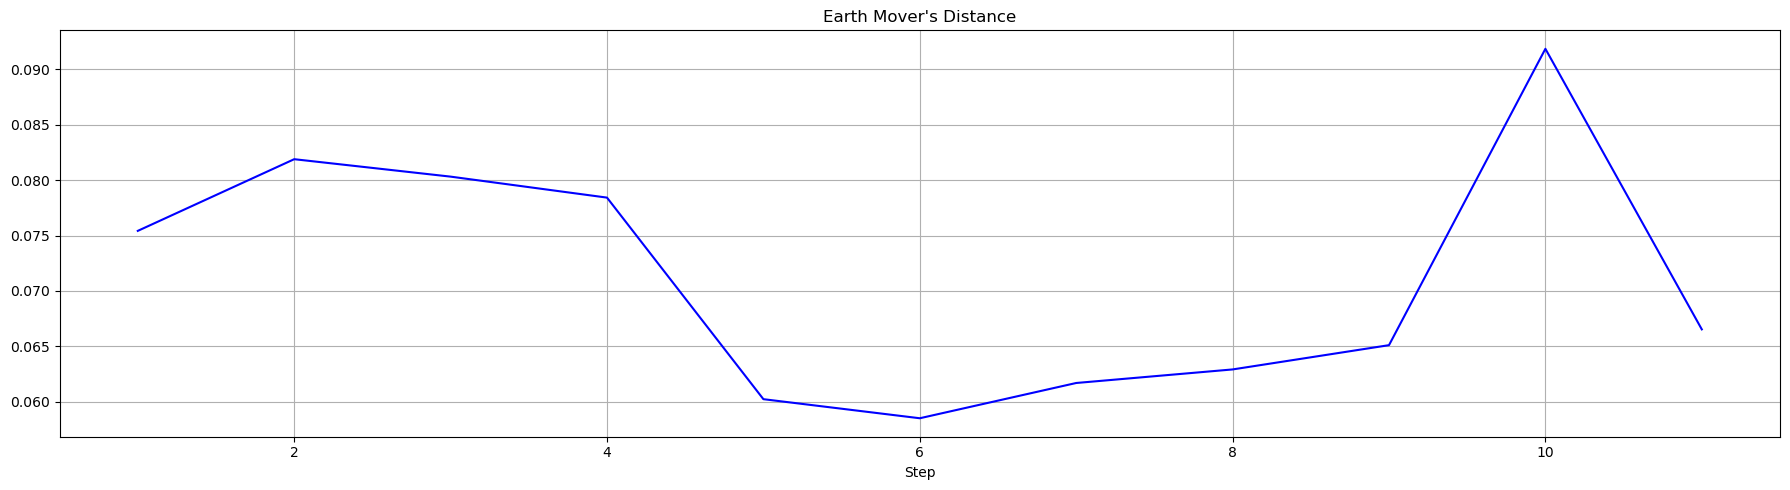

In [23]:
clip = 'small_mvt_20000'
EMD_small_mvt_20000 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

small_mvt_20000_emd = all_plot(EMD_small_mvt_20000, clip)

### Bar Plot

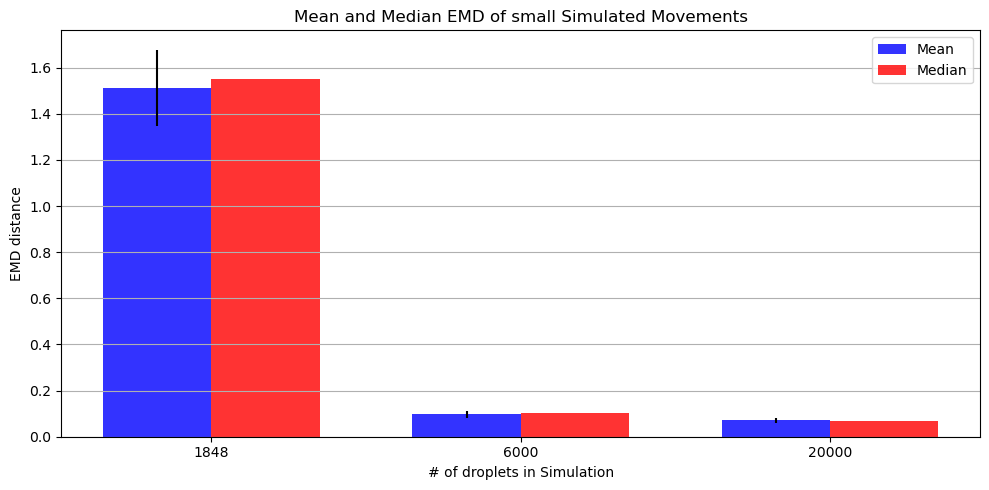

In [37]:
# bar plot of the mean EMD distances of SmallMov_Sparse
mean_emd_small_mvt = [np.mean(small_mvt_1848_emd), np.mean(small_mvt_6000_emd), np.mean(small_mvt_20000_emd)]
std_emd_small_mvt = [np.std(small_mvt_1848_emd), np.std(small_mvt_6000_emd), np.std(small_mvt_20000_emd)]
median_emd_small_mvt = [np.median(small_mvt_1848_emd), np.median(small_mvt_6000_emd), np.median(small_mvt_20000_emd)]

fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, mean_emd_small_mvt, bar_width, yerr=std_emd_small_mvt, alpha=opacity, color='b', label='Mean')
rects2 = ax.bar(index + bar_width, median_emd_small_mvt, bar_width, alpha=opacity, color='r', label='Median')

ax.set_xlabel('# of droplets in Simulation')
ax.set_ylabel('EMD distance')
ax.set_title('Mean and Median EMD of small Simulated Movements')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1848', '6000', '20000'))
ax.yaxis.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## Medium

#### 1848

Earth Mover's Distance with 30 bins:
Mean: 2.766 (std: 0.241)
Median: 2.767



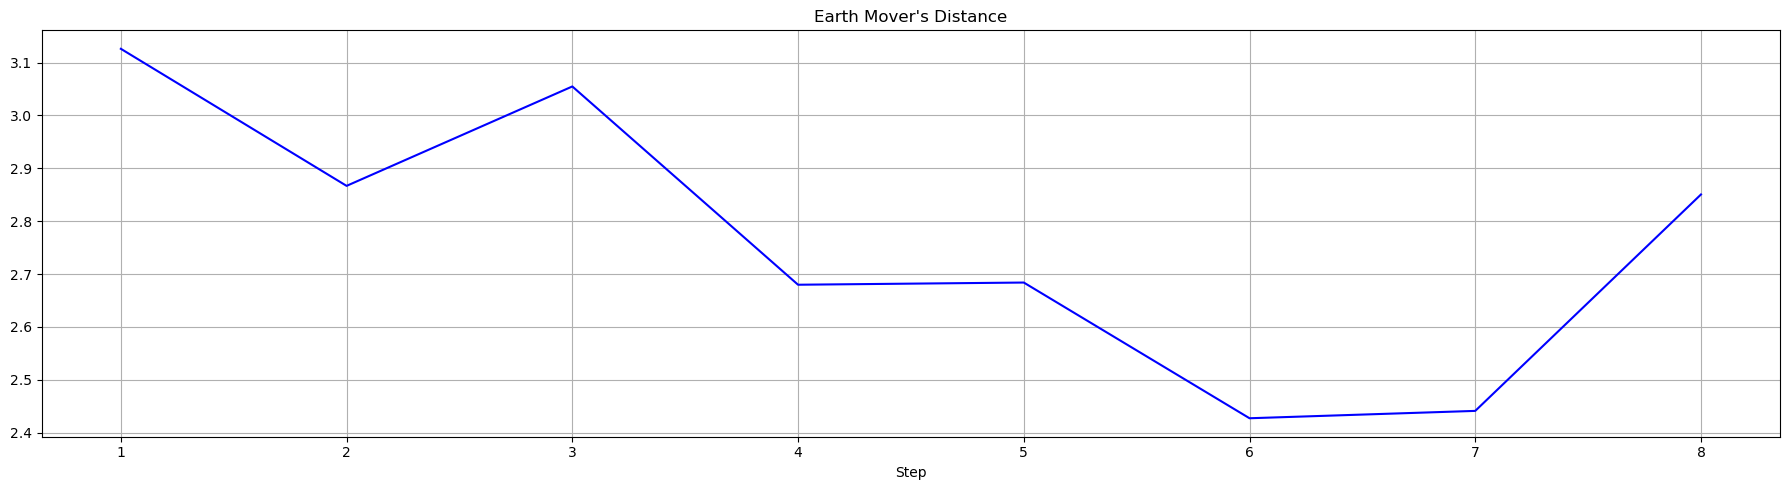

In [24]:
clip = 'medium_mvt_1848'
EMD_medium_mvt_1848 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

medium_mvt_1848_emd = all_plot(EMD_medium_mvt_1848, clip)

#### 6000

Earth Mover's Distance with 30 bins:
Mean: 3.362 (std: 0.667)
Median: 3.215



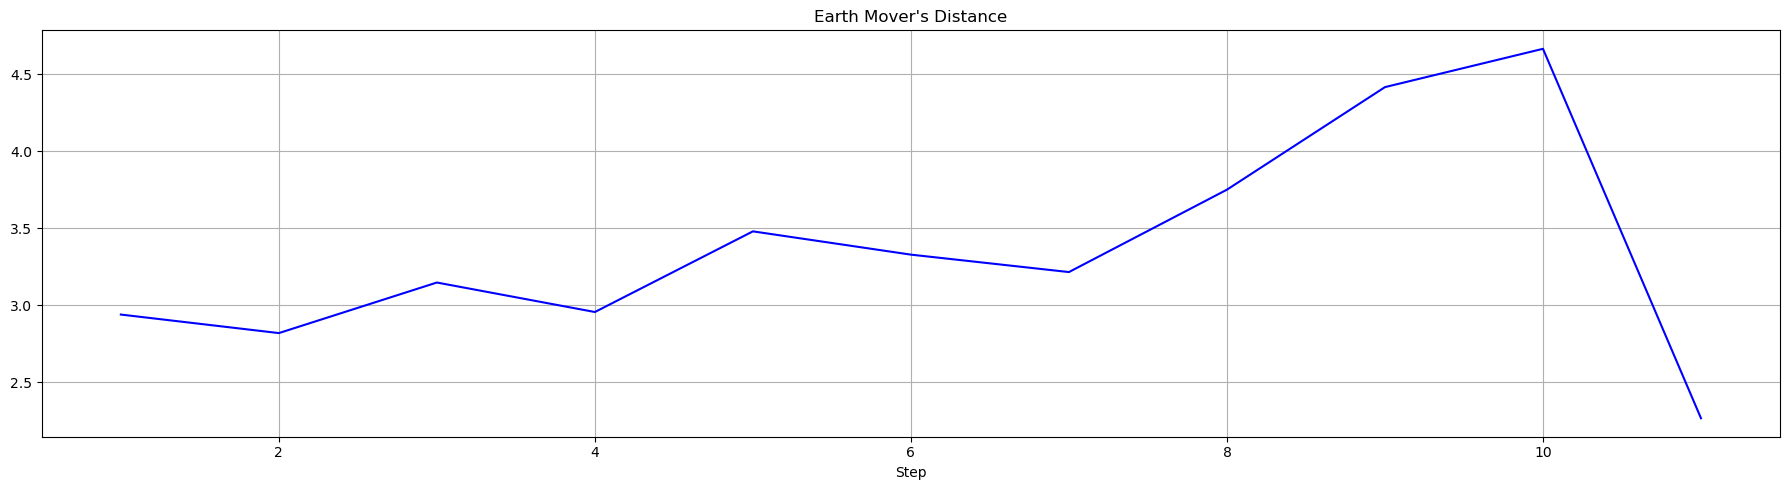

In [25]:
clip = 'medium_mvt_6000'
EMD_medium_mvt_6000 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

medium_mvt_6000_emd = all_plot(EMD_medium_mvt_6000, clip)

#### 20000

Earth Mover's Distance with 30 bins:
Mean: 2.845 (std: 0.708)
Median: 2.822



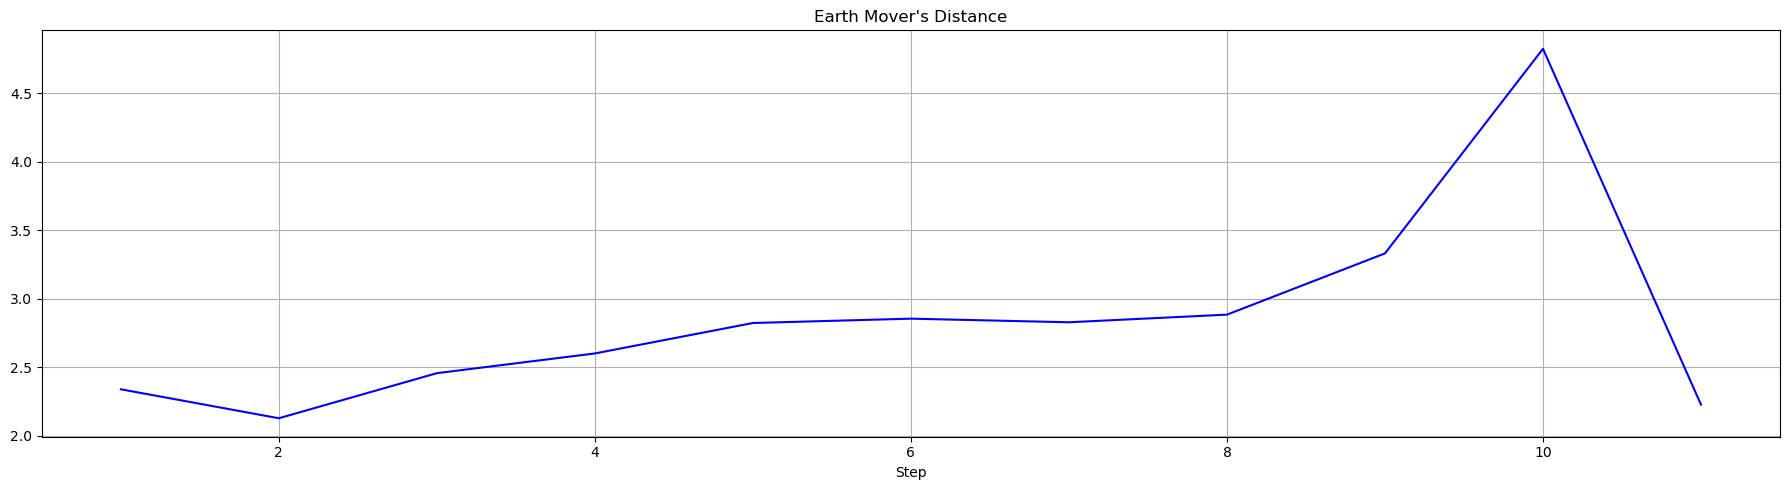

In [26]:
clip = 'medium_mvt_20000'
EMD_medium_mvt_20000 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

medium_mvt_20000_emd = all_plot(EMD_medium_mvt_20000, clip)

### Bar Plot

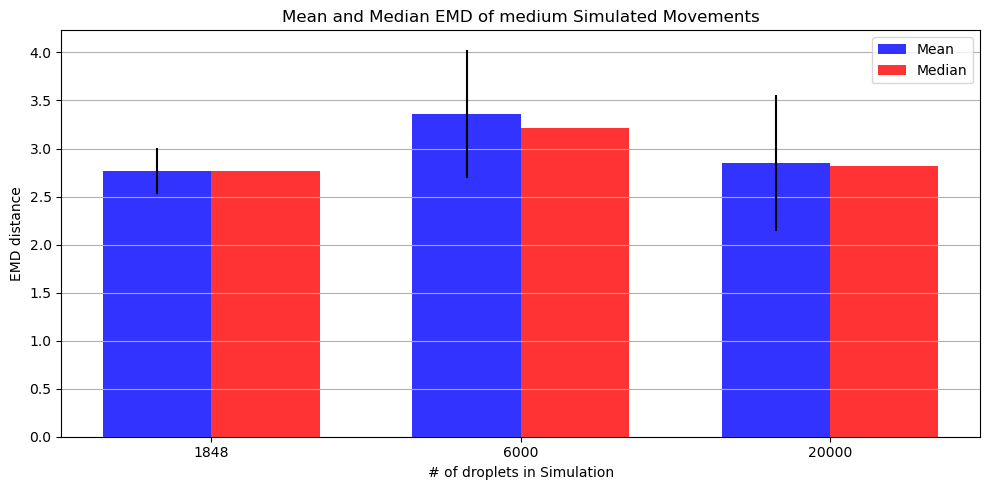

In [38]:
mean_emd_medium_mvt = [np.mean(medium_mvt_1848_emd), np.mean(medium_mvt_6000_emd), np.mean(medium_mvt_20000_emd)]
std_emd_medium_mvt = [np.std(medium_mvt_1848_emd), np.std(medium_mvt_6000_emd), np.std(medium_mvt_20000_emd)]
median_emd_medium_mvt = [np.median(medium_mvt_1848_emd), np.median(medium_mvt_6000_emd), np.median(medium_mvt_20000_emd)]

fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, mean_emd_medium_mvt, bar_width, yerr=std_emd_medium_mvt, alpha=opacity, color='b', label='Mean')
rects2 = ax.bar(index + bar_width, median_emd_medium_mvt, bar_width, alpha=opacity, color='r', label='Median')

ax.set_xlabel('# of droplets in Simulation')
ax.set_ylabel('EMD distance')
ax.set_title('Mean and Median EMD of medium Simulated Movements')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1848', '6000', '20000'))
ax.yaxis.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## Large

#### 1848

Earth Mover's Distance with 30 bins:
Mean: 4.148 (std: 0.380)
Median: 4.192



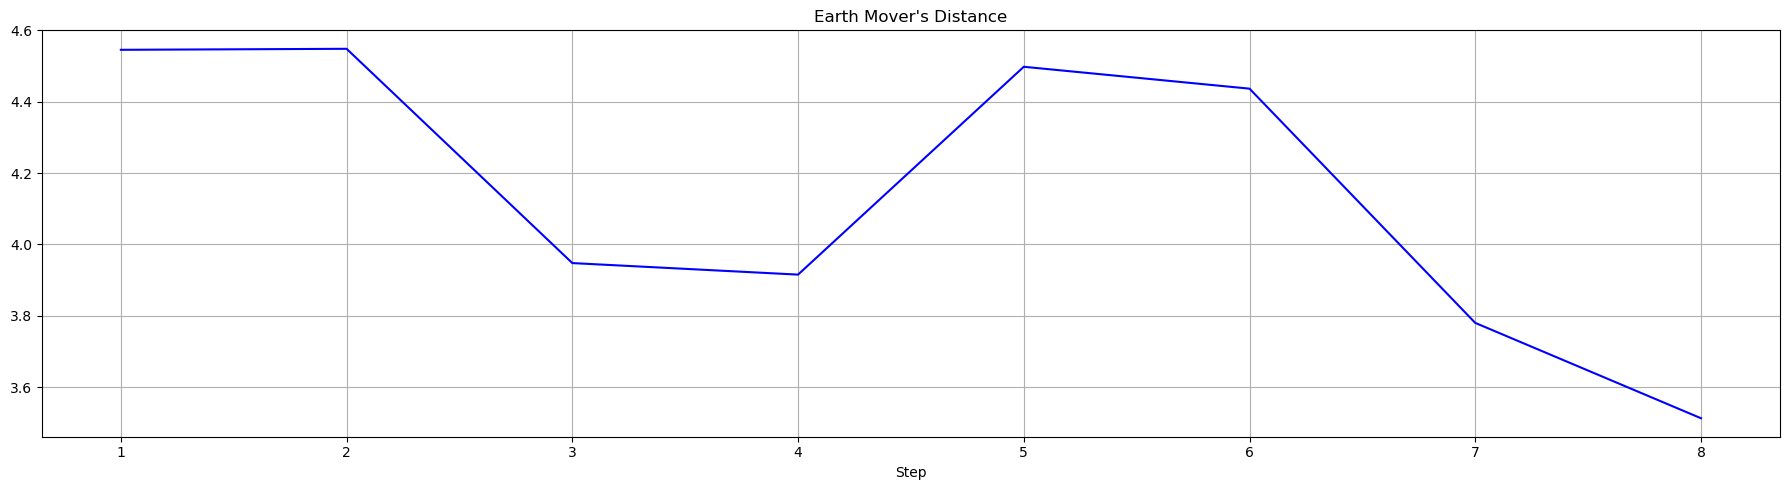

In [27]:
clip = 'large_mvt_1848'
EMD_large_mvt_1848 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

large_mvt_1848_emd = all_plot(EMD_large_mvt_1848, clip)

#### 6000

Earth Mover's Distance with 30 bins:
Mean: 13.090 (std: 1.070)
Median: 12.966



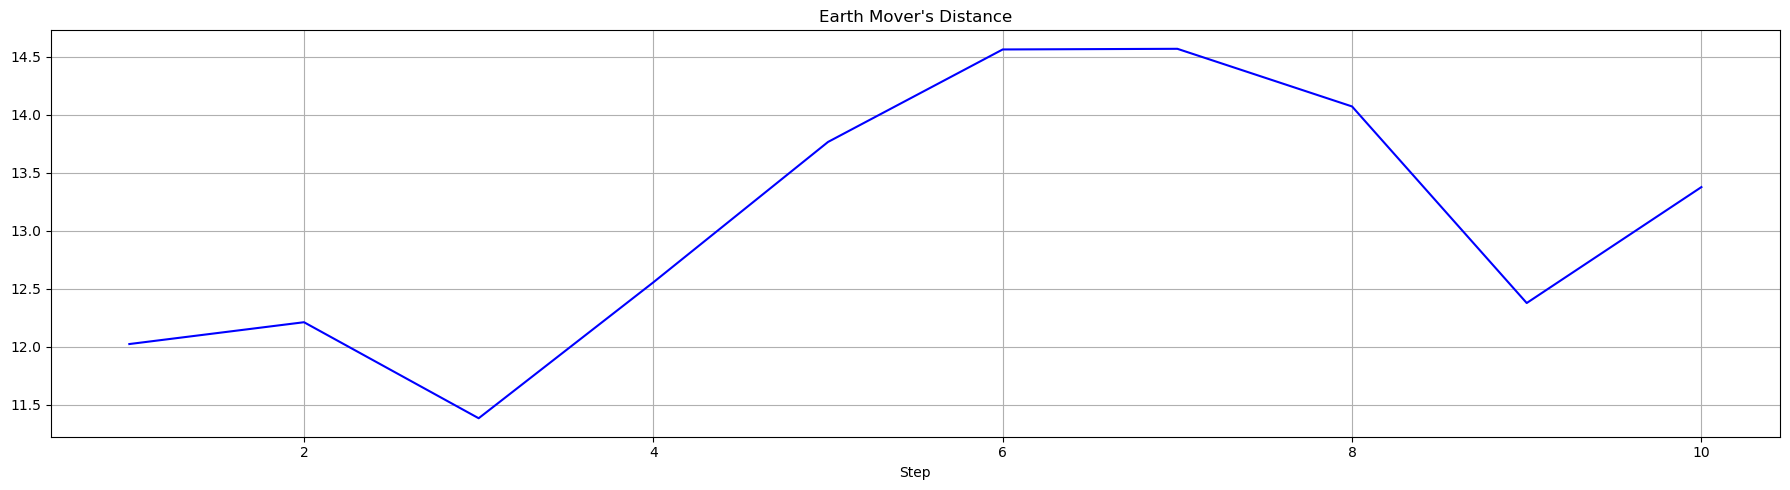

In [28]:
clip = 'large_mvt_6000'
EMD_large_mvt_6000 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

large_mvt_6000_emd = all_plot(EMD_large_mvt_6000, clip)

#### 20000

Earth Mover's Distance with 30 bins:
Mean: 13.029 (std: 1.464)
Median: 12.661



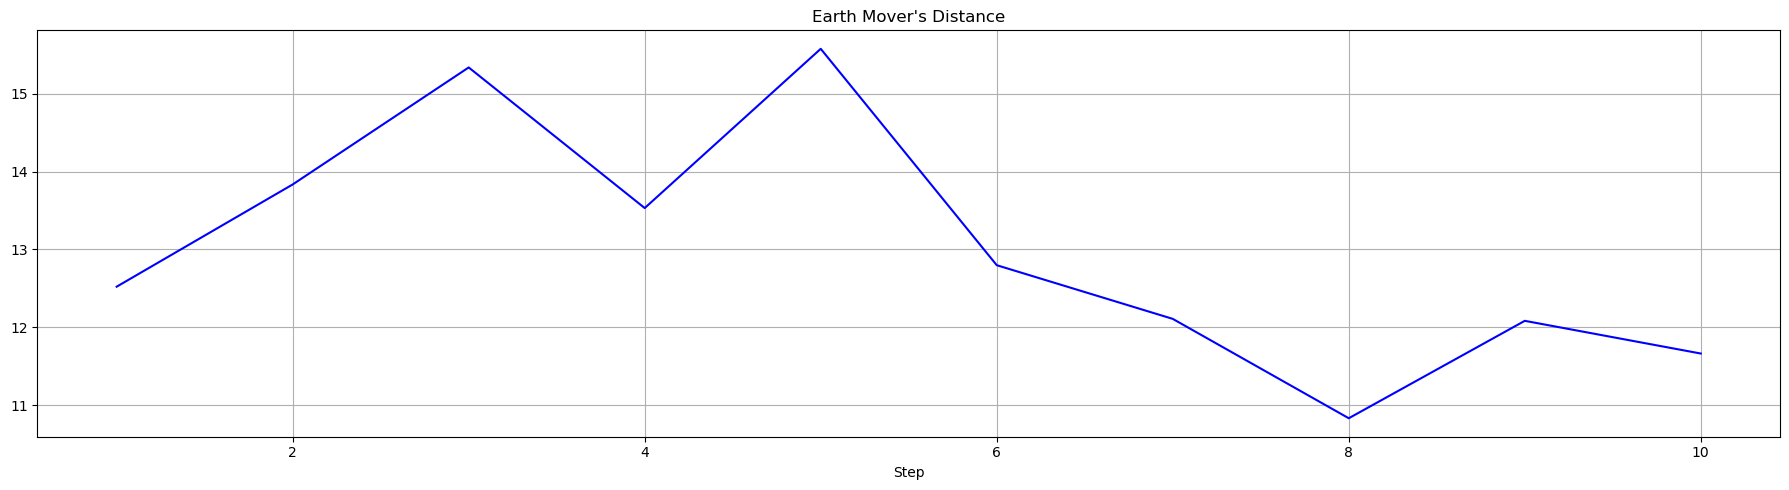

In [29]:
clip = 'large_mvt_20000'
EMD_large_mvt_20000 = EMD_Sim_Movement(Path(Path('evaluation/01_simulated') / Path(f'{clip}' + '_droplets.csv')))

large_mvt_20000_emd = all_plot(EMD_large_mvt_20000, clip)

#### Bar Plot

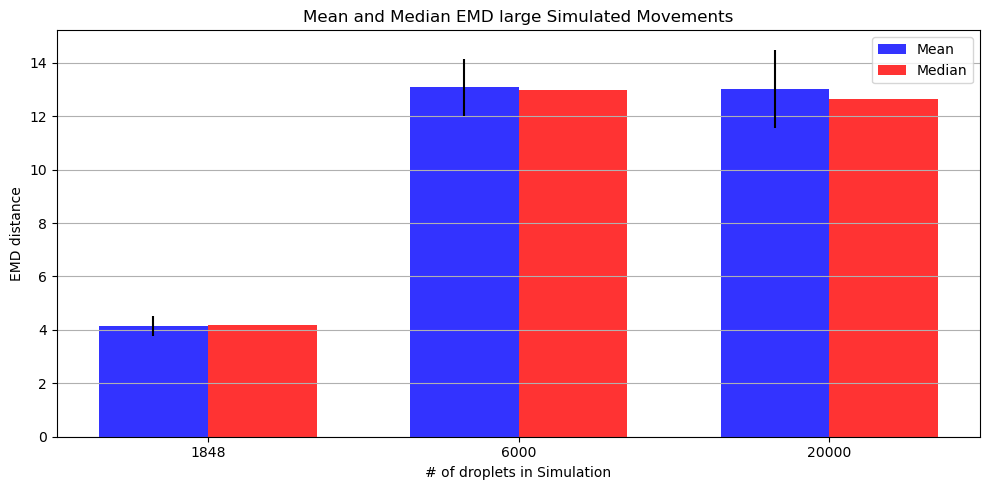

In [39]:
mean_emd_large_mvt = [np.mean(large_mvt_1848_emd), np.mean(large_mvt_6000_emd), np.mean(large_mvt_20000_emd)]
std_emd_large_mvt = [np.std(large_mvt_1848_emd), np.std(large_mvt_6000_emd), np.std(large_mvt_20000_emd)]
median_emd_large_mvt = [np.median(large_mvt_1848_emd), np.median(large_mvt_6000_emd), np.median(large_mvt_20000_emd)]

fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, mean_emd_large_mvt, bar_width, yerr=std_emd_large_mvt, alpha=opacity, color='b', label='Mean')
rects2 = ax.bar(index + bar_width, median_emd_large_mvt, bar_width, alpha=opacity, color='r', label='Median')

ax.set_xlabel('# of droplets in Simulation')
ax.set_ylabel('EMD distance')
ax.set_title('Mean and Median EMD large Simulated Movements')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1848', '6000', '20000'))
ax.yaxis.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## All Results

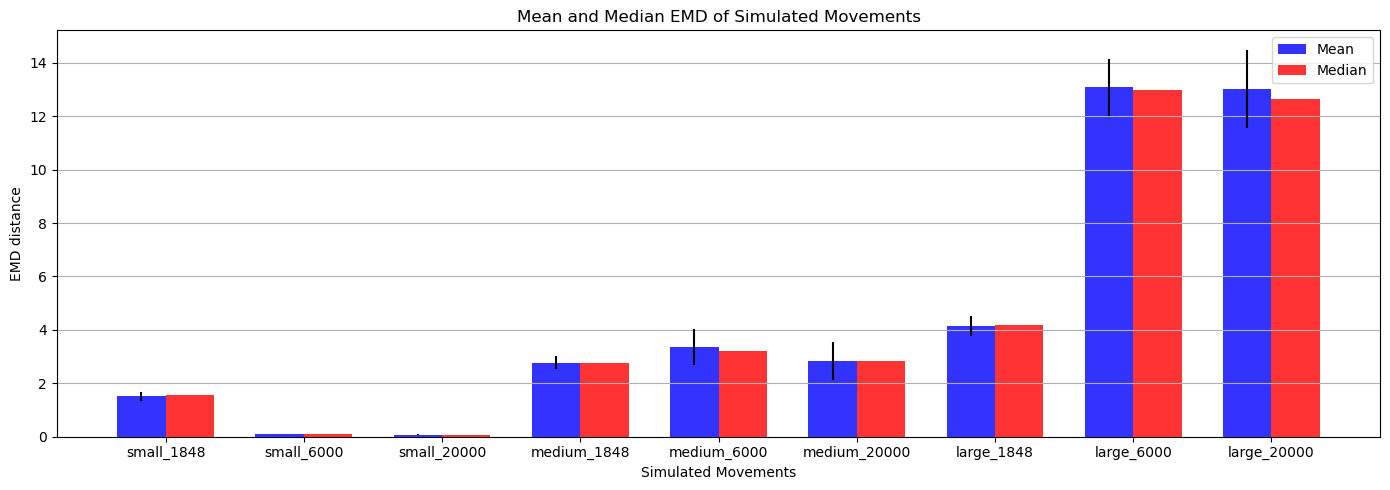

In [42]:
# one large bar plot of the mean EMD distances of all Simulated Movements

mean_emd = [np.mean(small_mvt_1848_emd), np.mean(small_mvt_6000_emd), np.mean(small_mvt_20000_emd),
            np.mean(medium_mvt_1848_emd), np.mean(medium_mvt_6000_emd), np.mean(medium_mvt_20000_emd),
            np.mean(large_mvt_1848_emd), np.mean(large_mvt_6000_emd), np.mean(large_mvt_20000_emd)]

std_emd = [np.std(small_mvt_1848_emd), np.std(small_mvt_6000_emd), np.std(small_mvt_20000_emd),
              np.std(medium_mvt_1848_emd), np.std(medium_mvt_6000_emd), np.std(medium_mvt_20000_emd),
              np.std(large_mvt_1848_emd), np.std(large_mvt_6000_emd), np.std(large_mvt_20000_emd)]

median_emd = [np.median(small_mvt_1848_emd), np.median(small_mvt_6000_emd), np.median(small_mvt_20000_emd),
                np.median(medium_mvt_1848_emd), np.median(medium_mvt_6000_emd), np.median(medium_mvt_20000_emd),
                np.median(large_mvt_1848_emd), np.median(large_mvt_6000_emd), np.median(large_mvt_20000_emd)]

fig, ax = plt.subplots(figsize=(14, 5))
index = np.arange(9)
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, mean_emd, bar_width, yerr=std_emd, alpha=opacity, color='b', label='Mean')
rects2 = ax.bar(index + bar_width, median_emd, bar_width, alpha=opacity, color='r', label='Median')

ax.set_xlabel('Simulated Movements')
ax.set_ylabel('EMD distance')
ax.set_title('Mean and Median EMD of Simulated Movements')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('small_1848', 'small_6000', 'small_20000', 'medium_1848', 'medium_6000', 'medium_20000', 'large_1848', 'large_6000', 'large_20000'))
ax.yaxis.grid(True)
ax.legend()

plt.tight_layout()
plt.show()